In [9]:
# import torch

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [10]:
import pandas as pd
from sklearn.metrics import classification_report

In [11]:
import pandas as pd
summary_50_train_x_df = pd.read_parquet("df/summary_50_train_df_x.gzip")
summary_100_train_x_df = pd.read_parquet("df/summary_100_train_df_x.gzip")
text_train_x_df = pd.read_parquet("df/text_train_df_x.gzip")

summary_50_train_df_y = pd.read_parquet("df/summary_50_train_df_y.gzip")
summary_100_train_df_y = pd.read_parquet("df/summary_100_train_df_y.gzip")
text_train_df_y = pd.read_parquet("df/text_train_df_y.gzip")


summary_50_test_x_df = pd.read_parquet("df/summary_50_test_df_x.gzip")
summary_100_test_x_df = pd.read_parquet("df/summary_100_test_df_x.gzip")
text_test_x_df = pd.read_parquet("df/text_test_df_x.gzip")

summary_50_test_df_y = pd.read_parquet("df/summary_50_test_df_y.gzip")
summary_100_test_df_y = pd.read_parquet("df/summary_100_test_df_y.gzip")
text_test_df_y = pd.read_parquet("df/text_test_df_y.gzip")

In [12]:
from xgboost import XGBClassifier

device = 'cpu'
def run_classifier(X_train, Y_train, X_test, Y_test, save_file=None):
    model = XGBClassifier(
        objective='multi:softprob',  # outputs class probabilities
        num_class=3,
        max_depth=8,                # Avoid extreme depth like 128
        tree_method='hist',     # Use GPU if available
        predictor='gpu_predictor',  # Use GPU for inference
        use_label_encoder=False,    # suppress warning
        eval_metric='mlogloss',
        device=device
    )

    model.fit(X_train, Y_train)

    # # Predict probabilities for each class
    # probs = model.predict_proba(X_test_updated)

    # Predict class labels
    preds = model.predict(X_test)

    print(classification_report(Y_test, preds, digits=4))

    if save_file:
        model.save_model(save_file)

    return model

In [18]:
# summary 100

model = run_classifier(
    X_train=text_train_x_df[[c for c in text_train_x_df.columns if c.startswith("topic") or c.startswith("sentiment")]], 
    Y_train=text_train_df_y,
    X_test=text_test_x_df[[c for c in text_train_x_df.columns if c.startswith("topic") or c.startswith("sentiment")]],
    Y_test=text_test_df_y,
    save_file="models/xgb_no_text_text_softprob.json"

)

/Users/upasana/code/playground/ci2_proj/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:18:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

         0.0     0.4506    0.9622    0.6137      3679
         1.0     0.9017    0.0708    0.1313      2203
         2.0     0.6395    0.2006    0.3054      3130

    accuracy                         0.4798      9012
   macro avg     0.6639    0.4112    0.3502      9012
weighted avg     0.6265    0.4798    0.3887      9012



In [ ]:
# monkey patch
booster = model.get_booster() 
model_bytearray = booster.save_raw()[4:]
booster.save_raw = lambda : model_bytearray

In [38]:
model = XGBClassifier()
model.load_model("models/xgb_text_softprob.json")

In [39]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer(text_train_x_df)
shap_values = shap_values.values

In [40]:
sentiment_indices = [i for i, col in enumerate(text_train_x_df.columns) if col.startswith("sentiment")]

In [41]:
import pandas as pd
import numpy as np

# Step 1: Extract subset of SHAP values for sentiment features
shap_subset = shap_values[:, sentiment_indices, :]  # shape: (n_samples, n_sentiment_features, 3)

# Step 2: Mean absolute SHAP across samples and classes
mean_abs_shap = np.abs(shap_subset).mean(axis=(0, 2))  # shape: (n_sentiment_features,)

# Step 3: Map back to feature names
top_features_df = pd.DataFrame({
    "feature": text_train_x_df.columns[sentiment_indices],
    "mean_abs_shap": mean_abs_shap
})

# Step 4: Sort and get top 10
top_10 = top_features_df.sort_values(by="mean_abs_shap", ascending=False).head(10)
print(top_10)

                            feature  mean_abs_shap
2060        sentiment Supreme Court       0.000474
2206             sentiment US House       0.000425
1177            sentiment Joe Biden       0.000417
683          sentiment Donald Trump       0.000370
872           sentiment Free Speech       0.000343
2283  sentiment Violence In America       0.000343
1715             sentiment Politics       0.000196
221        sentiment Bernie Sanders       0.000186
988            sentiment Healthcare       0.000134
1832     sentiment Republican Party       0.000117


In [45]:
top_features_df.sort_values(by="mean_abs_shap", ascending=False).head(10)

,feature,mean_abs_shap
2060,sentiment Supreme Court,0.000474
2206,sentiment US House,0.000425
1177,sentiment Joe Biden,0.000417
683,sentiment Donald Trump,0.000370
872,sentiment Free Speech,0.000343
2283,sentiment Violence In America,0.000343
1715,sentiment Politics,0.000196
221,sentiment Bernie Sanders,0.000186
988,sentiment Healthcare,0.000134
1832,sentiment Republican Party,0.000117


In [55]:
import joblib

joblib.dump(shap_subset, "shap_explanation_text.pkl")

['shap_explanation_text.pkl']

In [68]:
import numpy as np
import pandas as pd

def compute_grouped_shap_importance_3d(shap_values, feature_names):
    """
    Computes average absolute SHAP importance per group for each class.
    
    Args:
        shap_values (np.ndarray): SHAP values with shape (n_samples, n_features, n_classes)
        feature_names (List[str]): List of feature names (length = n_features)
    
    Returns:
        pd.DataFrame: Grouped importance per class
    """
    # Absolute mean SHAP per feature per class: shape (n_features, n_classes)
    mean_abs_shap = np.abs(shap_values).mean(axis=0)

    # Map feature indices to groups
    groups = {'sentiment': [], 'topic': [], 'text': []}
    for i, name in enumerate(feature_names):
        if name.startswith("sentiment"):
            groups["sentiment"].append(i)
        elif name.startswith("topic"):
            groups["topic"].append(i)
        else:
            groups["text"].append(i)

    # Compute group-wise average SHAP for each class
    group_importance = {}
    for group, indices in groups.items():
        if indices:
            # shape (len(indices), n_classes) → mean over features → (n_classes,)
            group_avg = mean_abs_shap[indices].mean(axis=0)
            group_importance[group] = group_avg

    # Convert to DataFrame for easy viewing
    pd.set_option("display.float_format", lambda x: f"{x:.8f}")
    importance_df = pd.DataFrame(group_importance)
    importance_df.index.name = "class"
    return importance_df


In [ ]:
compute_grouped_shap_importance_3d(shap_values, text_train_x_df.columns).to_csv("text_average_shap_feature_importance.csv")

In [1]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import joblib 

shap_values = joblib.load("shap_explanation_text.pkl")

In [ ]:
import numpy as np

def plot_all_feature_violin_subsampled(shap_values, class_labels=None, max_rows=3000):
    """
    Violin plot of SHAP values across all features and classes (subsampled to avoid memory overload).
    """
    n_samples, n_features, n_classes = shap_values.shape
    class_labels = class_labels or list(range(n_classes))

    # Subsample rows
    if n_samples > max_rows:
        idx = np.random.choice(n_samples, size=max_rows, replace=False)
    else:
        idx = np.arange(n_samples)

    df_records = []
    for c in range(n_classes):
        vals = np.abs(shap_values[idx, :, c]).flatten()
        df_records.extend([{"class": class_labels[c], "shap_value": v} for v in vals])

    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    df = pd.DataFrame(df_records)
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df, x="class", y="shap_value", inner="quartile", cut=0)
    plt.yscale("log")  # Optional: compress y-axis for better visualization
    plt.title("Distribution of |SHAP| Values Across All Features (Subsampled)")
    plt.xlabel("Class")
    plt.ylabel("Absolute SHAP Value")
    plt.tight_layout()
    plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
    plt.show()
    

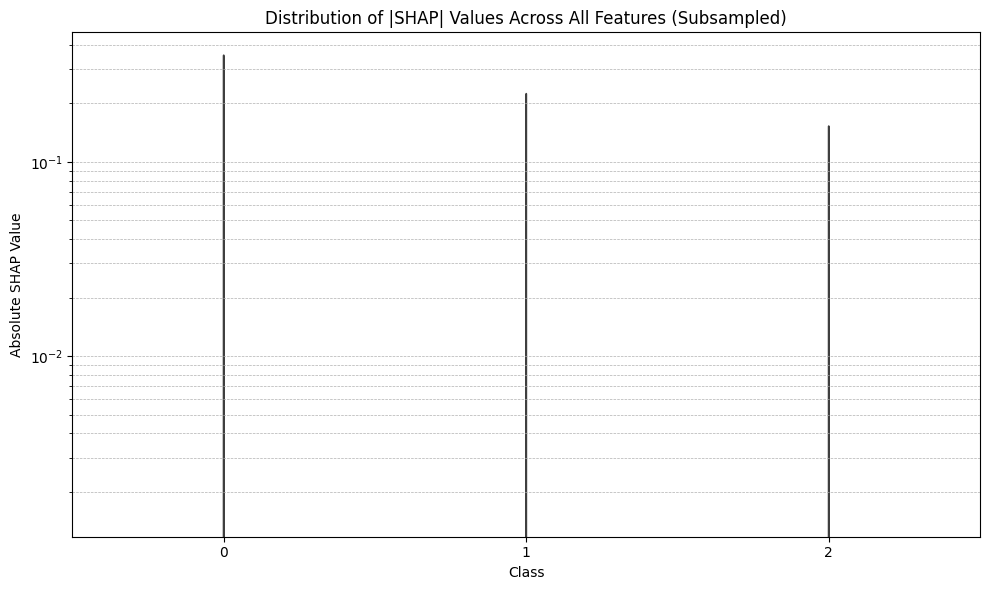

In [7]:
plot_all_feature_violin_subsampled(shap_values)